# Spectral denoising as feature engineering

In this notebook we investigate the use of Fourier and Wavelet tranforms as a denosing pre-processing step prior to time series forecasting. This approach can be summarised as:
- step 1: Spectral tranforms of time series data, a transform from the time to frequency domain
- step 2: filter out high frequency noise components.
- step 3: inverses tranforms the frequency signal back to the time domain.
- step 4: forecasting the denoised signal. 

In [1]:
# import my bespoke modules
from one_dimensional_time_series_forecasting import time_series_prediction, hit_rate, invert_first_difference,invert_first_difference_2,invert_scaling, invert_first_difference_with_log_2
from spectral_denoising import automatic_fourier_denoising

# model evalution metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error

# data preprocessing
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

# interactive figures
%matplotlib widget 

# general data wrangling and visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tabulate import tabulate



2022-05-12 18:05:40.665661: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-12 18:05:40.665686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# 1. Fourier methods

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-22,95.199997,96.889999,95.120003,96.730003,96.730003,252349
1,2014-01-23,96.690002,97.839996,96.410004,97.320000,97.320000,274078
2,2014-01-24,97.370003,97.800003,96.250000,96.639999,96.639999,239673
3,2014-01-27,96.900002,97.180000,95.209999,95.720001,95.720001,235110
4,2014-01-28,95.660004,97.660004,95.629997,97.410004,97.410004,206490
...,...,...,...,...,...,...,...
1995,2021-12-23,73.029999,73.949997,72.269997,73.790001,73.790001,270223
1996,2021-12-27,73.379997,76.089996,72.570000,75.570000,75.570000,268490
1997,2021-12-28,75.970001,76.919998,75.529999,75.980003,75.980003,249728
1998,2021-12-29,76.040001,77.370003,75.360001,76.559998,76.559998,283557


Threshold found! Threshold: 0.09516725704532791 Test: 96.03960396039604


/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/tristan/my_venvs/meng-data-science/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


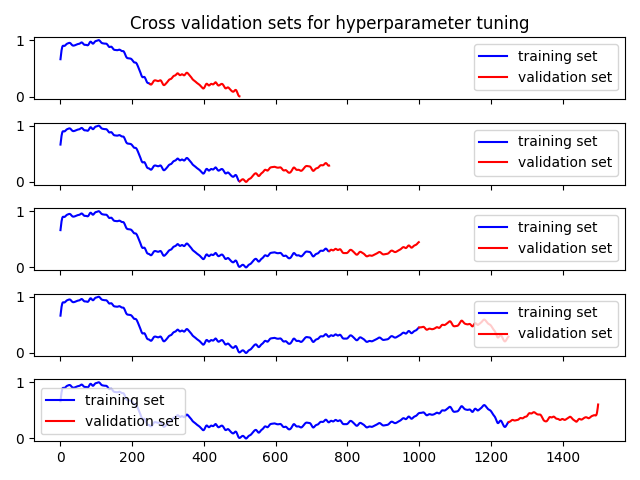


Training support vector machine:
Model params:  {'C': 0.1, 'cache_size': 200, 'coef0': 0.0, 'degree': 3, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'linear', 'max_iter': 5000, 'shrinking': True, 'tol': 0.001, 'verbose': False}
MAPE: 0.3862396770419908
RMSE:  0.04739290376068094
MAE:  0.03389030859686056

Training MLP neural network: 
Model params: {'activation': 'relu', 'alpha': 0.0001, 'batch_size': 'auto', 'beta_1': 0.9, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_fun': 15000, 'max_iter': 2000, 'momentum': 0.9, 'n_iter_no_change': 100, 'nesterovs_momentum': True, 'power_t': 0.5, 'random_state': 1, 'shuffle': False, 'solver': 'adam', 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
MAPE: 0.16209152390361156
RMSE:  0.03327611385695743
MAE:  0.020637793280772813

Training LSTM neural network: 
Epoch 1/2000
21/21 [=========================

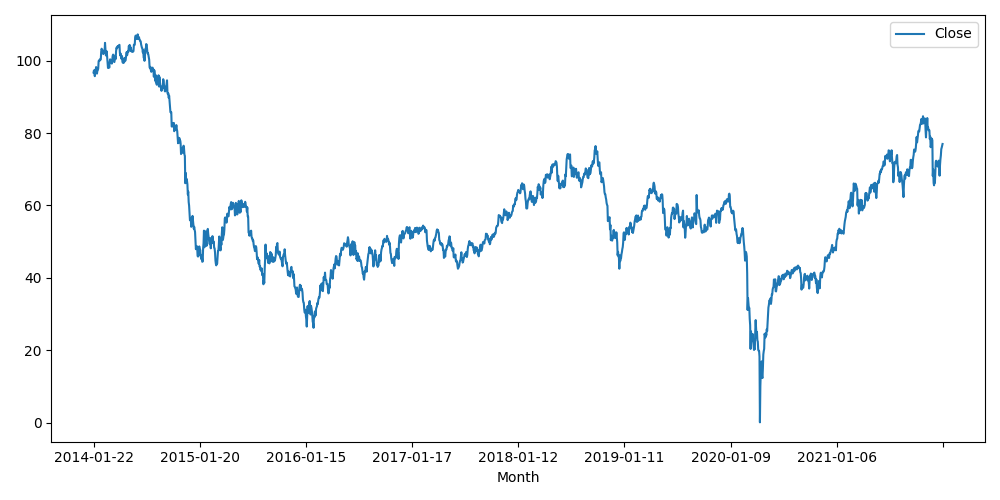

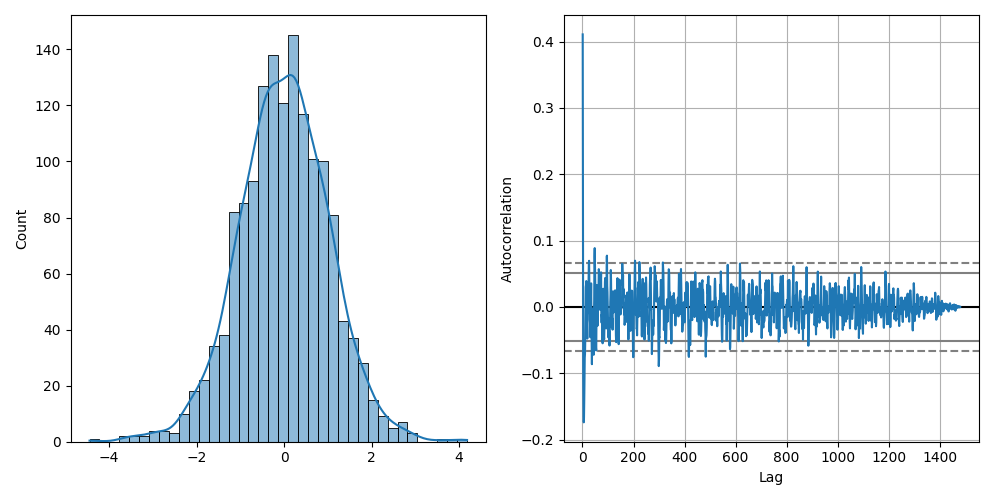

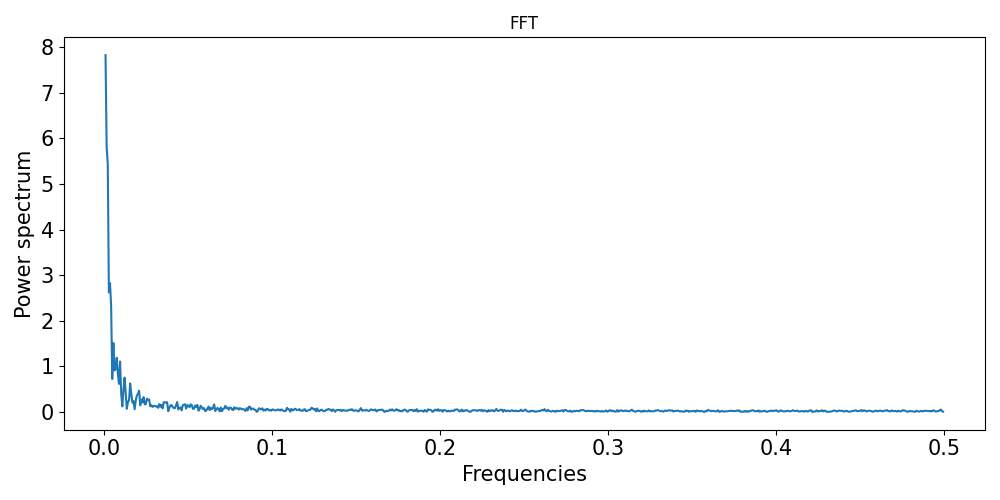

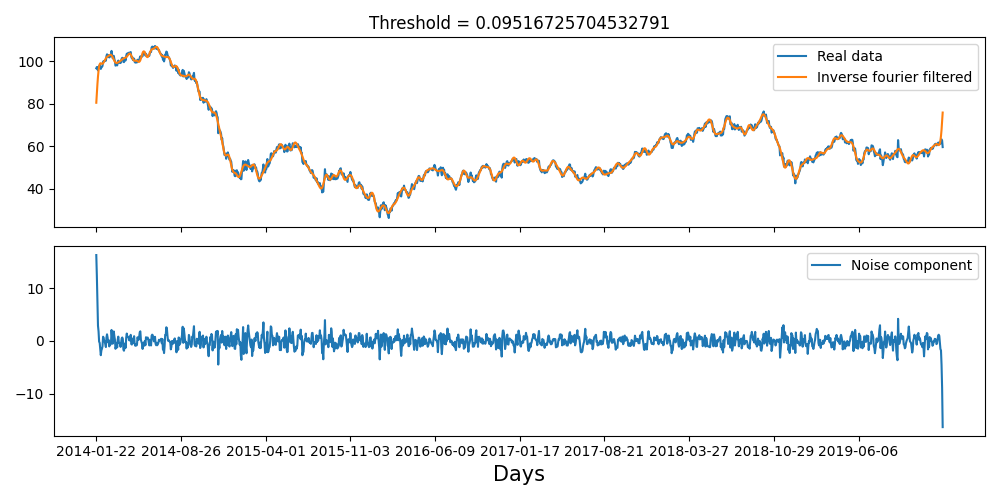

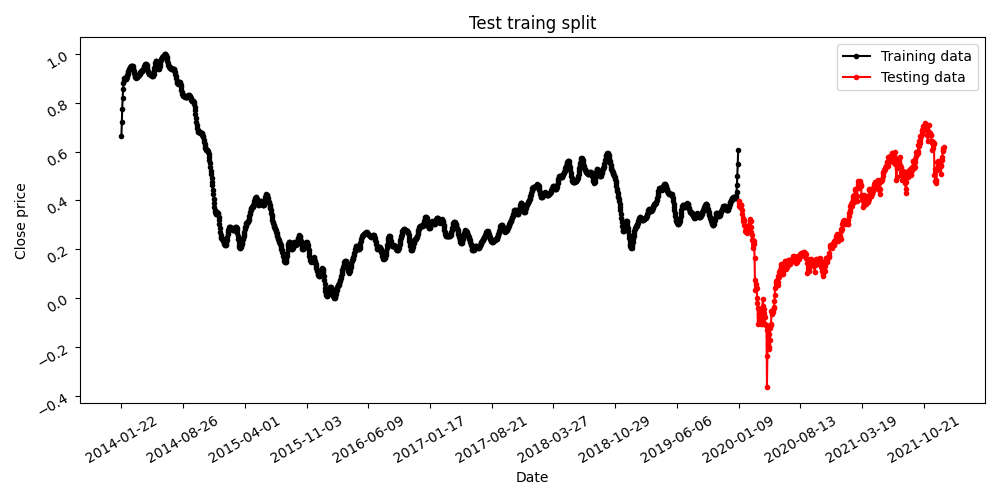

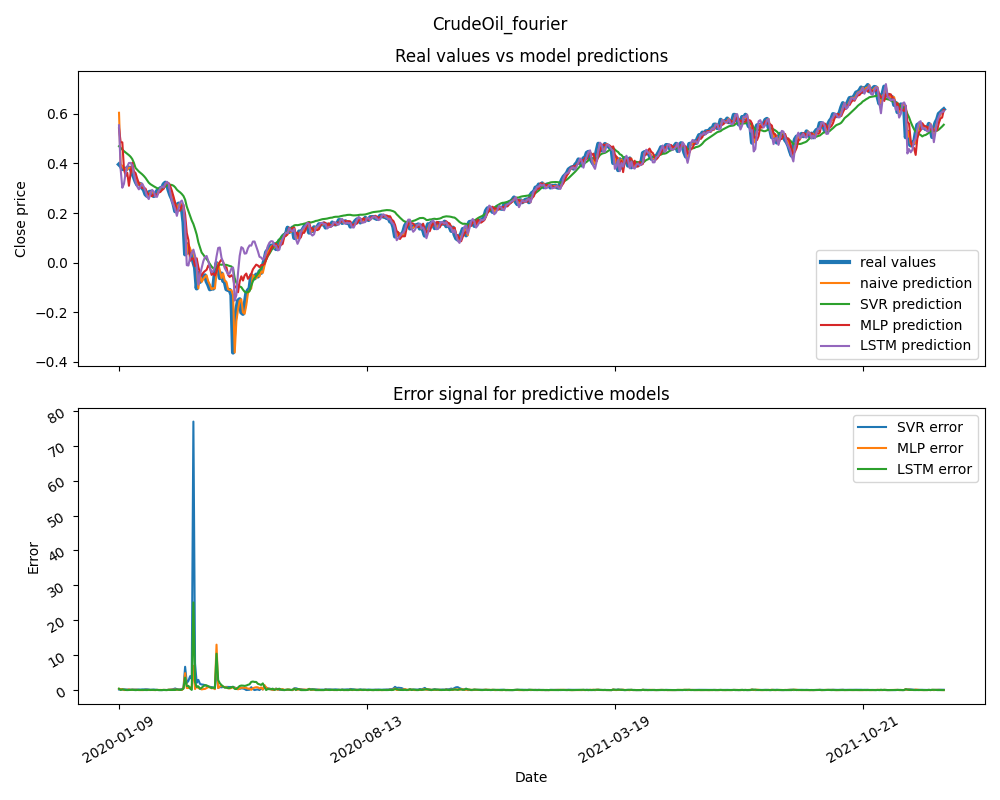

In [7]:
financial_assets = ['CrudeOil','S&P500','Apple','EurUsd'] # AirPassengers',
feat_engineering = 'fourier'
column_to_predict = 'Close' #'#Passengers' 

for financial_asset in financial_assets:
    ###################################################################################################
    # import some data
    ###################################################################################################

    df = pd.read_csv(f'./test_data/{financial_asset}_yfinance.csv') # sp_500 = GSPC.csv, # airplaine = AirPassengers.csv
    df = df.iloc[-2000:,:].reset_index(drop=True) # only look at last 2000 days
    # df['Date'] = df['Month']
    df.plot(x='Date',y=f'{column_to_predict}',figsize=(10,5),legend=True,xlabel='Month',subplots=True)
    plt.tight_layout()
    display(df)

    # some forecasting parameters
    window_length = 10
    split = 500 # 44 for AirPlane

    ###################################################################################################
    # feature engineering
    ###################################################################################################

    # fft the testing data
    signal = np.array(df[f'{column_to_predict}'][-2000:-split]) # data
    denoised_signal = automatic_fourier_denoising(signal,df, split)

    ###################################################################################################
    # single out of sample validation results
    ###################################################################################################

    # input data
    scaler = MinMaxScaler()
    scaled_training_data = scaler.fit_transform(denoised_signal.reshape(-1, 1)).flatten()
    scaled_test_data = scaler.transform(df[f'{column_to_predict}'][-split:].to_numpy().reshape(-1,1)).flatten()
    scaled_input_data = np.append(scaled_training_data,scaled_test_data)

    # initialize class object
    blah = time_series_prediction(financial_asset,feat_engineering,df['Date'],scaled_input_data,window_length,1)#time_series_prediction(sp_500['Date'][-4000:],sp_500['Volume'][-4000:]/1e9,5,1) # pass: ime series dates, univariate time series, lag window length, a number of steps ahead to predict
    blah.sliding_window_1(verbose=0) # time series to supervised ML problem
    blah.train_test_split(split=split) # testing and training dataset split
    blah.test_train_plot(ylabel='Close price')    # visualize training split

    # perform some prediction tasks
    blah.linear_regression()
    blah.support_vector_machine(model_tunning=True,C= 0.1, kernel= 'linear',epsilon=0.1)
    blah.neural_net_mlp(model_tunning=True,
                        activation= 'relu', 
                        hidden_layer_sizes= (100, 100, 100), 
                        learning_rate= 'invscaling', 
                        learning_rate_init= 0.001,
                        solver='adam')
    blah.lstm(model_tunning=True,n_batch=64)
    blah.naive_model()

    # tabulate results nicely
    blah.collect_results()

    # visualize results
    blah.vis_results_time_series(ylabel='Close price',second_plot='error')

    # view final results
    blah.conclusion()


    # ###################################################################################################
    # # walk forward validation results
    # ###################################################################################################
    # mapping = {'LinearReg':blah.linear_regression_model,
    #             'svr':blah.svr_model,
    #             'MLP':blah.mlp_model,
    #             'LSTM':blah.lstm_model}

    # # store evaulation results for different models
    # model_results = []
    # model_pred_results = {'Original Values':None,
    #             'LinearReg':None,
    #             'svr':None,
    #             'MLP':None,
    #             'LSTM':None,
    #             }

    # # apply walkforward for all models
    # for model_name in mapping.keys():

    #     # retrieve model
    #     model = mapping[model_name]

    #     # apply walk forward and save results
    #     train_len = 225 # 48 for Airplane
    #     test_len = 25   # 12 for Airplane
    #     df_walk_forward, df_hit_rate, mse,mae,mape,accuracy = blah.walk_forward_val(model_name,model,
    #                                                                                 train_len=train_len,
    #                                                                                 test_len=test_len,
    #                                                                                 train_frequency=10)
    #     # wrangle results
        
    #     # plots
    #     df_walk_forward['error'] = abs((df_walk_forward['real_value'] - df_walk_forward['prediction']))# / df_walk_forward['real_value'])
        
    #     fig, ax = plt.subplots(2,1, figsize=(10,8),sharex=True)
    #     ax[0].plot(df_walk_forward['date'],df_walk_forward['real_value'])
    #     ax[0].set_ylabel('Close')

    #     ax[1].plot(df_walk_forward['date'],df_walk_forward['error'],color='tab:orange')
    #     ax[1].set_title('Walk forward error through time')
    #     ax[1].set_xlabel('Dates')
    #     ax[1].legend()

    #     max = df_walk_forward.shape[0]
    #     ax[1].set_xticks([df_walk_forward['date'].iloc[x] for x in range(0,max,150)])
    #     ax[1].tick_params(rotation=30)
    #     ax[1].set_ylabel('Error')
    #     ax[1].set_xlabel('Date')
    #     plt.tight_layout()
    #     plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_{model_name}_wf.png',facecolor='w')
    #     plt.close()

    #     # tables 
    #     model_results.append({'model':model_name,'mse':mse,'mae':mae,'mape':mape,'accuracy':accuracy})

    #     # save prediction so we can view inverted walk forward results too
    #     model_pred_results['Original Values'] = df_walk_forward['real_value'].to_numpy()
    #     model_pred_results[model_name] = df_walk_forward['prediction'].to_numpy()
        
    # # place wf results into df, save to csv and latex table
    # df_conclusion_wf = pd.DataFrame.from_records(model_results)
    # df_conclusion_wf.to_csv(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_results_summary_wf.csv')    
    
    # latex_table = tabulate(df_conclusion_wf, headers='keys', tablefmt="latex_longtable")
    # with open(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_latex_table_wf.txt',"w") as my_latex_table:
    #     my_latex_table.write(latex_table)

    # # plot wf prediction results through time
    # for model in model_pred_results.keys():
    #     model_pred_results[model] = model_pred_results[model].astype(float)

    # model_pred_results['Date'] = df['Date'].iloc[train_len:]
    # df_wf_results = pd.DataFrame.from_dict(model_pred_results)
    # ax = df_wf_results.plot(figsize=(10,4), x='Date',fontsize=15)
    # ax.set_ylabel(ylabel=f'{column_to_predict}',fontsize=15)
    # ax.set_xlabel(xlabel='Date',fontsize=15)
    # ax.tick_params(labelsize=12,rotation=30)

    # plt.tight_layout()
    # plt.savefig(f'./results/univariate_single_step_ahead/{feat_engineering}/{financial_asset}_wf_results.png')

